In [1]:
print("hello")

hello


In [2]:
!pip install torch==2.3.1+cu118 torchvision==0.18.1+cu118 torchaudio==2.3.1 --extra-index-url https://download.pytorch.org/whl/cu118 torchtext==0.18.0 tmnt==0.7.56 transformers==4.40.1 pyOpenSSL==18.0.0 cryptography==42.0.5 numpy pandas scikit-learn

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 135.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 124.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.4/283.4 kB 42.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 10.3

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())

CUDA available: True
Number of GPUs: 1
Current device: 0


In [2]:
from tmnt.estimator import SeqBowEstimator
import numpy as np
import os
import logging
import torch
import pandas as pd
from tmnt.preprocess.vectorizer import TMNTVectorizer
from tmnt.inference import SeqVEDInferencer
from tmnt.distribution import LogisticGaussianDistribution
from tmnt.utils.log_utils import logging_config
from tmnt.data_loading import get_llm_dataloader
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.utils import shuffle

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [ ]:
# Load the new dataset
file_path = 'cleaned_correctness.csv'
data = pd.read_csv(file_path)

# Extract relevant columns
queries = data['question'].tolist()
ground_truths = data['answer'].tolist()
responses = data['responses'].tolist()
labels = data['correct'].astype(int).tolist()

# Combine query, ground truth, and response for input
combined_inputs = [f"Query: {q} Ground Truth: {gt} Response: {r}" for q, gt, r in zip(queries, ground_truths, responses)]

# Vectorizer
vectorizer = TMNTVectorizer(vocab_size=2000, count_vectorizer_kwargs={'token_pattern': r'\b[A-Za-z][A-Za-z][A-Za-z]+\b'})
X, _ = vectorizer.fit_transform(combined_inputs)

# Logging Configuration
use_logging = True
if use_logging:
    logging_config(folder='.', name='f_seqbow_binary_classification', level='info', console_level='info')
    log_method = 'log'
else:
    log_method = 'print'

# DataLoader Preparation
tf_llm_name = 'distilbert-base-uncased'
batch_size = 16
seq_len = 256

# Prepare datasets for dataloaders
train_size = int(0.8 * len(data))  # 80% training data, 20% validation data
train_ds = list(zip(labels[:train_size], combined_inputs[:train_size]))
dev_ds = list(zip(labels[train_size:], combined_inputs[train_size:]))

label_map = {0: 0, 1: 1}

device_str = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_loader = get_llm_dataloader(train_ds, vectorizer, tf_llm_name, label_map, batch_size, seq_len, device=device_str)
dev_loader = get_llm_dataloader(dev_ds, vectorizer, tf_llm_name, label_map, batch_size, seq_len, device=device_str)

# Model Initialization
num_topics = 20  # Keeping it same, but it's not used for binary classification
latent_distribution = LogisticGaussianDistribution(768, num_topics, dr=0.1, alpha=2.0, device=device_str)
device = torch.device(device_str)

estimator = SeqBowEstimator(
    llm_model_name=tf_llm_name,
    latent_distribution=latent_distribution,
    n_labels=2,  # Binary classification
    vocabulary=vectorizer.get_vocab(),
    batch_size=batch_size,
    device=device,
    log_interval=1,
    log_method=log_method,
    gamma=100.0,
    lr=2e-5,
    decoder_lr=0.01,
    epochs=4
)

# Train and save the model
estimator.fit_with_validation(train_loader, dev_loader, aux_data=None)

os.makedirs('_model_dir', exist_ok=True)
estimator.write_model('./_model_dir')

# Print training and validation accuracy separately
train_accuracy = estimator.validate(estimator.model, train_loader)
val_accuracy = estimator.validate(estimator.model, dev_loader)
print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

# Inference Object
inferencer = SeqVEDInferencer(estimator, max_length=seq_len, pre_vectorizer=vectorizer)

# Example inference
test_query = "What is the largest planet in our solar system?"
test_ground_truth = "Jupiter"
test_response = "Jupiter is the largest planet in our solar system."
test_input = f"Query: {test_query} Ground Truth: {test_ground_truth} Response: {test_response}"

# Transform and predict
token_result = inferencer.vectorizer.transform([test_input])

# Debug print to check token_result
print(token_result)

# Check if attention mask is None and handle it
if token_result[1] is None:
    print("Attention mask is not generated.")
else:
    # Convert the sparse matrix to dense tensor and move to the device
    input_ids = torch.tensor(token_result[0].todense()).to(device)
    attention_mask = torch.tensor(token_result[1].todense()).to(device)

    # Perform the prediction
    predictions = inferencer.model.forward_encode(input_ids, attention_mask)
    print(predictions)  # Should print the classification of the response as "correct" or "incorrect"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/tmnt/data_loading.py:213: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  i = torch.LongTensor(indices)
/usr/local/lib/python3.10/dist-packages/tmnt/data_loading.py:217: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  return torch.sparse.FloatTensor(i, v, s)
2025-03-12 23:48:49,091 - root - Number of warmup steps = 40, num total train steps = 400, batch_size = 16, epochs = 4


In [ ]:
from tmnt.estimator import SeqBowEstimator
import numpy as np
import os
import logging
import torch
import pandas as pd
from transformers import AutoTokenizer
from tmnt.inference import SeqVEDInferencer
from tmnt.distribution import LogisticGaussianDistribution
from tmnt.utils.log_utils import logging_config
from tmnt.data_loading import get_llm_dataloader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

# --- Define a Hybrid Vectorizer ---
class HybridVectorizer:
    """
    A hybrid vectorizer that produces both a bag-of-words representation (using CountVectorizer)
    and transformer-based attention masks (using a Hugging Face tokenizer).
    """
    def __init__(self, tf_model_name, vocab_size=2000, count_vectorizer_kwargs=None, max_length=256):
        if count_vectorizer_kwargs is None:
            count_vectorizer_kwargs = {}
        self.count_vectorizer = CountVectorizer(max_features=vocab_size, **count_vectorizer_kwargs)
        self.tokenizer = AutoTokenizer.from_pretrained(tf_model_name)
        self.max_length = max_length

    def fit_transform(self, texts):
        # Fit the CountVectorizer on texts and generate BoW representation (sparse matrix)
        bow = self.count_vectorizer.fit_transform(texts)
        # Tokenize texts with transformer tokenizer to obtain attention masks
        tokenized = self.tokenizer(
            texts,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        attn_mask = tokenized["attention_mask"]
        return bow, attn_mask

    def transform(self, texts):
        bow = self.count_vectorizer.transform(texts)
        tokenized = self.tokenizer(
            texts,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        attn_mask = tokenized["attention_mask"]
        return bow, attn_mask

    def get_vocab(self):
        return self.count_vectorizer.vocabulary_

# --- Load and Prepare the Data ---
file_path = 'cleaned_correctness.csv'
data = pd.read_csv(file_path)

# Extract relevant columns
queries = data['question'].tolist()
ground_truths = data['answer'].tolist()
responses = data['responses'].tolist()
labels = data['correct'].astype(int).tolist()

# Combine query, ground truth, and response for input
combined_inputs = [
    f"Query: {q} Ground Truth: {gt} Response: {r}"
    for q, gt, r in zip(queries, ground_truths, responses)
]

# --- Vectorizer and DataLoader Setup ---
tf_llm_name = 'distilbert-base-uncased'
batch_size = 16
seq_len = 256

# Use the hybrid vectorizer (it will produce both a BoW sparse matrix and attention masks)
vectorizer = HybridVectorizer(
    tf_model_name=tf_llm_name,
    vocab_size=2000,
    count_vectorizer_kwargs={'token_pattern': r'\b[A-Za-z][A-Za-z][A-Za-z]+\b'},
    max_length=seq_len
)

# (Optionally run fit_transform to initialize and inspect outputs)
X, attn = vectorizer.fit_transform(combined_inputs)
print("BoW shape:", X.shape)
print("Attention mask shape:", attn.shape)

# Logging Configuration
use_logging = True
if use_logging:
    logging_config(folder='.', name='f_seqbow_binary_classification', level='info', console_level='info')
    log_method = 'log'
else:
    log_method = 'print'

# Prepare datasets for dataloaders (80% train, 20% validation)
train_size = int(0.8 * len(data))
train_ds = list(zip(labels[:train_size], combined_inputs[:train_size]))
dev_ds = list(zip(labels[train_size:], combined_inputs[train_size:]))

label_map = {0: 0, 1: 1}

device_str = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_loader = get_llm_dataloader(train_ds, vectorizer, tf_llm_name, label_map, batch_size, seq_len, device=device_str)
dev_loader = get_llm_dataloader(dev_ds, vectorizer, tf_llm_name, label_map, batch_size, seq_len, device=device_str)

# --- Model Initialization ---
# Note: The latent distribution uses a 768-dimensional input (matching DistilBERT's hidden size)
num_topics = 20  # Not used for binary classification but required by the API
latent_distribution = LogisticGaussianDistribution(768, num_topics, dr=0.1, alpha=2.0, device=device_str)
device = torch.device(device_str)

estimator = SeqBowEstimator(
    llm_model_name=tf_llm_name,
    latent_distribution=latent_distribution,
    n_labels=2,  # Binary classification
    vocabulary=vectorizer.get_vocab(),
    batch_size=batch_size,
    device=device,
    log_interval=1,
    log_method=log_method,
    gamma=100.0,
    lr=2e-5,
    decoder_lr=0.01,
    epochs=4
)

# --- Train and Save the Model ---
estimator.fit_with_validation(train_loader, dev_loader, aux_data=None)

os.makedirs('_model_dir', exist_ok=True)
estimator.write_model('./_model_dir')

# Print training and validation accuracy separately
train_accuracy = estimator.validate(estimator.model, train_loader)
val_accuracy = estimator.validate(estimator.model, dev_loader)
print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

# --- Inference Using the Hybrid Vectorizer ---
# Create an inference object using our hybrid vectorizer
inferencer = SeqVEDInferencer(estimator, max_length=seq_len, pre_vectorizer=vectorizer)

# Example inference
test_query = "What is the largest planet in our solar system?"
test_ground_truth = "Jupiter"
test_response = "Jupiter is the largest planet in our solar system."
test_input = f"Query: {test_query} Ground Truth: {test_ground_truth} Response: {test_response}"

# Use the hybrid vectorizer to tokenize the input and get both BoW and attention mask
bow, attention_mask = vectorizer.transform([test_input])
# (Note: the BoW is not used by the transformer encoder; it's used by the latent topic part)
# Here we move the attention mask to the device.
input_attention_mask = attention_mask.to(device)

# For inference, we use the transformer part from the LLM.
# Depending on your model architecture, the model's forward_encode method should accept input_ids and attention_mask.
# We'll assume here that the inference object extracts input_ids internally using the tokenizer.
# Thus, we call forward_encode with the attention mask.
# If your model expects both input_ids and attention_mask, you can get input_ids as:
tokenized = vectorizer.tokenizer(
    [test_input],
    max_length=seq_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)
input_ids = tokenized["input_ids"].to(device)
# Now perform the prediction using both inputs
predictions = inferencer.model.forward_encode(input_ids, input_attention_mask)
print("Predictions:", predictions)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


BoW shape: (1998, 2000)
Attention mask shape: torch.Size([1998, 256])


2025-03-11 19:10:53,698 - root - Number of warmup steps = 40, num total train steps = 400, batch_size = 16, epochs = 4
/usr/local/lib/python3.10/dist-packages/tmnt/estimator.py:1156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.metric.update(torch.tensor(out), torch.tensor(label))
2025-03-11 19:10:53,847 - root - Epoch 1 Batch 1/100 loss=224.690185546875, (rec_loss = 144.201171875), (red_loss = 1.7772294282913208), (class_loss = 0.8048900961875916) lr=0.0000005000, metrics[AUPRC]: 0.5092719793319702
2025-03-11 19:10:53,987 - root - Epoch 1 Batch 2/100 loss=280.1813049316406, (rec_loss = 183.95172119140625), (red_loss = 1.8436479568481445), (class_loss = 0.9622959494590759) lr=0.0000010000, metrics[AUPRC]: 0.5215557813644409
2025-03-11 19:10:54,122 - root - Epoch 1 Batch 3/100 loss=301.236328125, (rec_loss = 231.293701171875), (red

Training Accuracy: ({'ppl': 40845009298.97488, 'npmi': 0.12749433484763012, 'redundancy': 0.03610000000000002, 'accuracy': tensor(0.9992)}, ['AuPRC'], [tensor(0.9992)])
Validation Accuracy: ({'ppl': 377.2148089673709, 'npmi': 0.12749433484763012, 'redundancy': 0.03610000000000002, 'accuracy': tensor(0.9319)}, ['AuPRC'], [tensor(0.9319)])
Predictions: tensor([[ 0.0825, -0.1974,  0.6188,  1.6215,  0.1203, -0.1608,  0.4321, -0.7732,
          0.1117,  1.0926,  1.0385,  1.0659, -0.0986, -1.0060,  1.0886, -1.6489,
          0.9659, -1.2805,  0.3112, -0.2875]], device='cuda:0',
       grad_fn=<NativeBatchNormBackward0>)


In [ ]:
import torch

# Example inference input
test_query = "What is the largest planet in our solar system?"
test_ground_truth = "Jupiter is the largest planet in our solar system"
test_response = "Akrofuom is located in the Ashanti Region of Ghana."
# test_response = "Jupiter is the largest planet"
test_input = f"Query: {test_query} Ground Truth: {test_ground_truth} Response: {test_response}"

# Tokenize the input using the same transformer tokenizer from our hybrid vectorizer.
encoding = vectorizer.tokenizer(
    [test_input],
    max_length=seq_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)
input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)

# Pass the tokenized input through the model's encoder to get the latent representation.
latent = estimator.model.forward_encode(input_ids, attention_mask)

# Pass the latent representation through the classifier head to obtain logits.
logits = estimator.model.classifier(latent)

# Apply softmax to get probabilities.
predictions = torch.softmax(logits, dim=-1)

# Choose the predicted class.t
predicted_class = torch.argmax(predictions, dim=-1).item()

print("Logits:", logits)
print("Predictions (probabilities):", predictions)
print("Predicted class:", predicted_class)

Logits: tensor([[-0.6631,  0.4883]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predictions (probabilities): tensor([[0.2402, 0.7598]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predicted class: 1


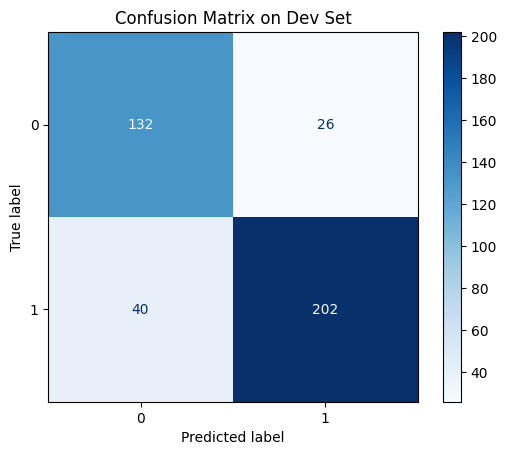

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set the model to evaluation mode
estimator.model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in dev_loader:
        # If the batch is wrapped in an extra tuple layer, unwrap it.
        if isinstance(batch, (list, tuple)) and len(batch) == 1:
            batch = batch[0]

        # Now we expect the batch to have at least three elements: labels, input_ids, and attention_mask.
        if not (isinstance(batch, (list, tuple)) and len(batch) >= 3):
            print("Unexpected batch format:", batch)
            raise ValueError("Dev Loader batch does not contain expected elements.")

        labels = batch[0]
        input_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)

        # Pass the inputs through the encoder and then the classifier head.
        latent = estimator.model.forward_encode(input_ids, attention_mask)
        logits = estimator.model.classifier(latent)
        predictions = torch.softmax(logits, dim=-1)
        preds = torch.argmax(predictions, dim=-1)

        # Collect the ground truth and predicted labels.
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Compute the confusion matrix.
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Dev Set")
plt.show()

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set the model to evaluation mode
estimator.model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in dev_loader:
        # If the batch is wrapped in an extra tuple, unwrap it.
        if isinstance(batch, (list, tuple)) and len(batch) == 1:
            batch = batch[0]

        # Now we expect at least three elements: labels, input_ids, attention_mask.
        if not (isinstance(batch, (list, tuple)) and len(batch) >= 3):
            print("Unexpected batch format:", batch)
            raise ValueError("Dev Loader batch does not contain expected elements.")

        labels = batch[0]
        input_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)

        # Get latent representation from encoder
        latent = estimator.model.forward_encode(input_ids, attention_mask)
        # Pass through classifier head to obtain logits
        logits = estimator.model.classifier(latent)
        # Convert logits to probabilities and select the class with the highest probability
        predictions = torch.softmax(logits, dim=-1)
        preds = torch.argmax(predictions, dim=-1)

        # Accumulate labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate metrics using scikit-learn
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.835
Precision: 0.8859649122807017
Recall: 0.8347107438016529
F1 Score: 0.8595744680851064
